In [436]:
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torch.optim import AdamW
import numpy as np
import gc
import wandb
from io import BytesIO
import plotly

In [344]:
# set the device we will be using to train the model
device = torch.device("cuda")

In [345]:
device

device(type='cuda')

In [138]:
wandb.login(key='API_KEY')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [139]:
wandb.init(project="PROJECT", entity='ENTITY')

In [346]:
# !wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip
# !unzip nature_12K.zip

In [349]:
np.random.seed(27)

In [350]:
training_data_path = "inaturalist_12K/train/"

In [377]:
config = {
    'n_neurons':1024,
    'n_neurons1':512,
    'dropout': 0.5,
    'weight_decay': 1e-2,
    'n_classes': 10,
    'learning_rate':5e-5,
    'batch_size':32,
    'epochs':100,
}

In [378]:
transform = transforms.Compose([
  transforms.Resize((299, 299)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225],
                          inplace=False),
])

In [379]:
training_data = ImageFolder(root=training_data_path, transform=transform)
train_size = int(0.8 * len(training_data))
val_size = len(training_data) - train_size
train_set, validation_set = random_split(training_data, [train_size, val_size])
train_dataloader = DataLoader(train_set, batch_size=config['batch_size'], shuffle=True)
val_dataloader = DataLoader(validation_set, batch_size=config['batch_size'], shuffle=False)

In [380]:
model = models.inception_v3(weights=None, init_weights=False)

In [381]:
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [382]:
# Load the pre-trained InceptionV3 model
model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT, init_weights=False)

In [383]:
def train_model():
    training_loss, training_accuracy, validation_loss, validation_accuracy = [],  [],  [], []
    gc.collect()
    torch.cuda.empty_cache()

    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.fc.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    print("Initiating Training")
    for epoch in range(0, config['epochs']):
        running_loss, running_accuracy, running_batch = 0,0,0
        model.train()
        for (x, y) in train_dataloader:
            optimizer.zero_grad()
            (x, y) = (x.to(device), y.to(device))
            pred = model(x)
            loss = criterion(pred.logits, y)
            running_loss += loss.item()*x.size()[0]
            running_accuracy += (pred.logits.argmax(1)==y).sum().item()
            running_batch +=y.size()[0]
            loss.backward()
            optimizer.step()
            del x
            del y
        training_loss.append(running_loss/len(train_dataloader.dataset))
        training_accuracy.append(100*(running_accuracy/running_batch))

        running_loss, running_accuracy, running_batch = 0,0,0
        with torch.no_grad():
            model.eval()
            for (x, y) in val_dataloader:
                (x, y) = (x.to(device), y.to(device))
                pred = model(x)
                loss = criterion(pred, y)
                running_loss += loss.item()*x.size()[0]
                running_accuracy += (pred.argmax(1)==y).sum().item()
                running_batch +=y.size()[0]
                del x
                del y
        validation_loss.append(running_loss/len(val_dataloader.dataset))
        validation_accuracy.append(100*(running_accuracy/running_batch))
        gc.collect()
        torch.cuda.empty_cache()
        print(f"Epoch: {epoch+1}/{config['epochs']}")
    return training_loss, training_accuracy, validation_loss, validation_accuracy

In [384]:
# Replace the last fully connected layer
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, config['n_neurons']),
    nn.ReLU(),
    nn.Linear(config['n_neurons'], config['n_neurons1']),
    nn.ReLU(),
    nn.Linear(config['n_neurons1'], config['n_classes']),
)

In [385]:
for name, param in model.named_parameters():
    if "fc" in name or "Mixed_7c":
        param.requires_grad = True
    else:
        param.requires_grad = False

In [386]:
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [387]:
model = model.to(device)
training_loss, training_accuracy, validation_loss, validation_accuracy = train_model()

Initiating Training
Epoch: 1/100
Epoch: 2/100
Epoch: 3/100
Epoch: 4/100
Epoch: 5/100
Epoch: 6/100
Epoch: 7/100
Epoch: 8/100
Epoch: 9/100
Epoch: 10/100
Epoch: 11/100
Epoch: 12/100
Epoch: 13/100
Epoch: 14/100
Epoch: 15/100
Epoch: 16/100
Epoch: 17/100
Epoch: 18/100
Epoch: 19/100
Epoch: 20/100
Epoch: 21/100
Epoch: 22/100
Epoch: 23/100
Epoch: 24/100
Epoch: 25/100
Epoch: 26/100
Epoch: 27/100
Epoch: 28/100
Epoch: 29/100
Epoch: 30/100
Epoch: 31/100
Epoch: 32/100
Epoch: 33/100
Epoch: 34/100
Epoch: 35/100
Epoch: 36/100
Epoch: 37/100
Epoch: 38/100
Epoch: 39/100
Epoch: 40/100
Epoch: 41/100
Epoch: 42/100
Epoch: 43/100
Epoch: 44/100
Epoch: 45/100
Epoch: 46/100
Epoch: 47/100
Epoch: 48/100
Epoch: 49/100
Epoch: 50/100
Epoch: 51/100
Epoch: 52/100
Epoch: 53/100
Epoch: 54/100
Epoch: 55/100
Epoch: 56/100
Epoch: 57/100
Epoch: 58/100
Epoch: 59/100
Epoch: 60/100
Epoch: 61/100
Epoch: 62/100
Epoch: 63/100
Epoch: 64/100
Epoch: 65/100
Epoch: 66/100
Epoch: 67/100
Epoch: 68/100
Epoch: 69/100
Epoch: 70/100
Epoch: 71

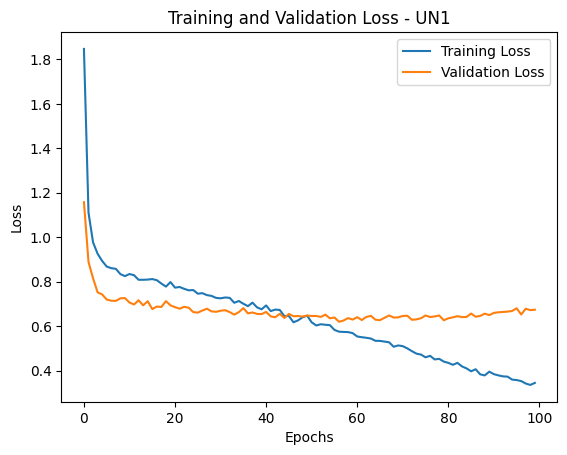

In [441]:
# Plotting
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss - UN1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
wandb.log({"inceptionv3_loss:fc": wandb.Image(plt)})
plt.show()

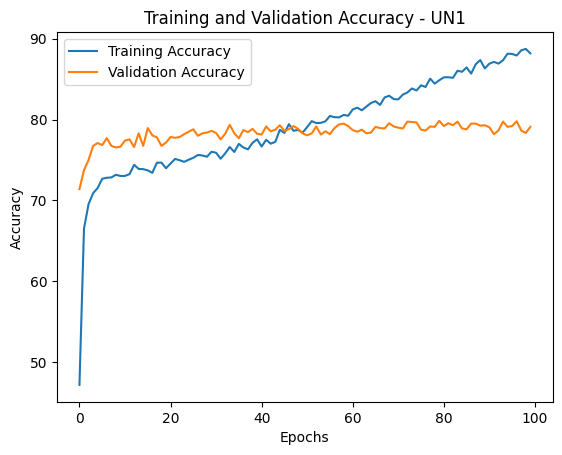

In [440]:
# Plotting
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy - UN1')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
wandb.log({"inceptionv3_accuracy:fc": wandb.Image(plt)})
plt.show()

In [391]:
config['epochs'] = 5

In [392]:
for name, param in model.named_parameters():
    if "Mixed_7b" in name:
        param.requires_grad = True

In [393]:
training_loss1, training_accuracy1, validation_loss1, validation_accuracy1 = train_model()

Initiating Training
Epoch: 1/5
Epoch: 2/5
Epoch: 3/5
Epoch: 4/5
Epoch: 5/5


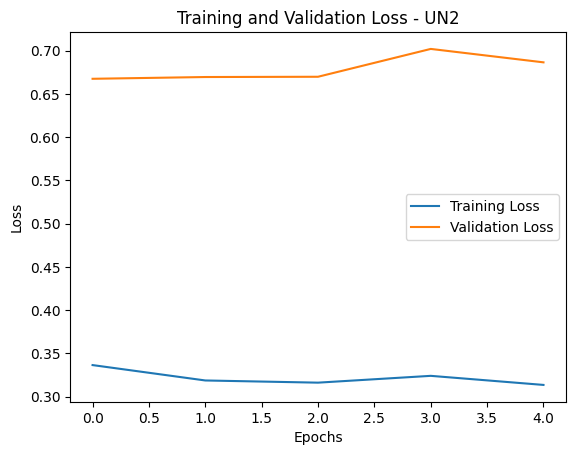

In [442]:
# Plotting
plt.plot(training_loss1, label='Training Loss')
plt.plot(validation_loss1, label='Validation Loss')
plt.title('Training and Validation Loss - UN2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
wandb.log({"inceptionv3_loss:7b": wandb.Image(plt)})
plt.legend()
plt.show()

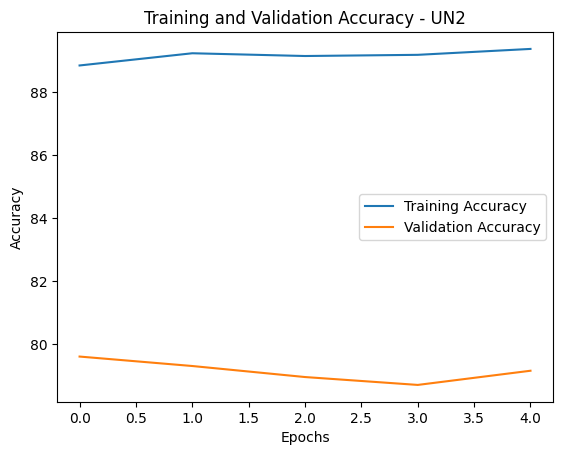

In [443]:
# Plotting
plt.plot(training_accuracy1, label='Training Accuracy')
plt.plot(validation_accuracy1, label='Validation Accuracy')
plt.title('Training and Validation Accuracy - UN2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
wandb.log({"inceptionv3_accuracy:7b": wandb.Image(plt)})
plt.legend()
plt.show()

In [404]:
torch.save(model.state_dict(), "inceptionv3")

In [405]:
torch.save(model, "inceptionv3.pt")

# Test Model

In [396]:
test_data_path = "inaturalist_12K/val/"

In [397]:
transform = transforms.Compose([
  transforms.Resize((299, 299)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225],
                          inplace=False),
])

In [398]:
test_data = ImageFolder(root=test_data_path, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=config['batch_size'], shuffle=True)

In [399]:
def test_model():
    test_loss, test_accuracy = [],  []
    gc.collect()
    torch.cuda.empty_cache()
    criterion = nn.CrossEntropyLoss()
    running_loss, running_accuracy, running_batch = 0,0,0
    with torch.no_grad():
        model.eval()
        for (x, y) in test_dataloader:
            (x, y) = (x.to(device), y.to(device))
            pred = model(x)
            loss = criterion(pred, y)
            running_loss += loss.item()*x.size()[0]
            running_accuracy += (pred.argmax(1)==y).sum().item()
            running_batch +=y.size()[0]
            del x
            del y
    test_loss.append(running_loss/len(val_dataloader.dataset))
    test_accuracy.append(100*(running_accuracy/running_batch))
    gc.collect()
    torch.cuda.empty_cache()

    return test_loss, test_accuracy

In [400]:
test_loss, test_accuracy = test_model()

In [401]:
test_loss[0]

0.6762989268302918

In [402]:
test_accuracy[0]

78.75